In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

✅ Jeu d'entraînement : (256204, 12)
✅ Jeu de test : (109803, 12)

🎯 Accuracy du modèle KNN : 0.7308

🧾 Rapport de classification :
              precision    recall  f1-score   support

           1       0.85      0.89      0.87     18235
           2       0.78      0.81      0.80     33054
           3       0.66      0.69      0.68     29581
           4       0.67      0.67      0.67     17238
           5       0.59      0.47      0.52      8519
           6       0.74      0.44      0.55      2850
           7       0.24      0.03      0.05       326

    accuracy                           0.73    109803
   macro avg       0.65      0.57      0.59    109803
weighted avg       0.73      0.73      0.73    109803



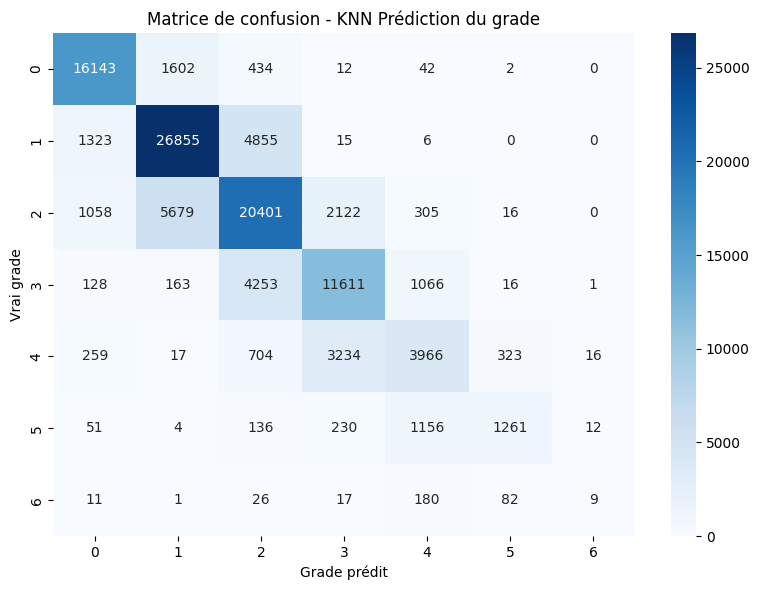

In [4]:
# 🔹 Chargement des données
input_path = "../../data/processed/dataset_clean_no_outliers.parquet"
df = pd.read_parquet(input_path)

# 🔹 Encodage rapide (si pas déjà fait)
grade_order = sorted(df['grade'].dropna().unique())
grade_mapping = {grade: idx + 1 for idx, grade in enumerate(grade_order)}
df['grade_encoded'] = df['grade'].map(grade_mapping)

# Encodage supplémentaire
df['home_ownership_encoded'] = df['home_ownership'].astype('category').cat.codes
df['verification_status_encoded'] = df['verification_status'].astype('category').cat.codes
df['loan_status_encoded'] = (df['loan_status'] == 'Charged Off').astype(int)
df['purpose_encoded'] = df['purpose'].astype('category').cat.codes
df['initial_list_status_encoded'] = df['initial_list_status'].map({'w': 1, 'f': 0})
df['application_type_encoded'] = df['application_type'].astype('category').cat.codes

# 🔹 Sélection des variables explicatives
features = [
    'int_rate', 'term', 'revol_util', 'loan_amnt', 'dti', 
    'installment', 'monthly_payment_calculated', 
    'home_ownership_encoded', 'verification_status_encoded',
    'purpose_encoded', 'initial_list_status_encoded',
    'application_type_encoded'
]

X = df[features]
y = df['grade_encoded']

# 🔥 Gérer les valeurs manquantes avant KNN
X = X.dropna()  # OPTION 1 : suppression des lignes avec NaN
y = y.loc[X.index]  # Important : aligner y avec X

# 🔹 Standardisation obligatoire pour KNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 Découpage Train / Test (70%-30%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print(f"✅ Jeu d'entraînement : {X_train.shape}")
print(f"✅ Jeu de test : {X_test.shape}")

# 🔹 Modèle KNN
knn = KNeighborsClassifier(n_neighbors=5)  # k=5 par défaut
knn.fit(X_train, y_train)

# 🔹 Prédictions
y_pred = knn.predict(X_test)

# 🔹 Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Accuracy du modèle KNN : {accuracy:.4f}")

print("\n🧾 Rapport de classification :")
print(classification_report(y_test, y_pred))

# 🔹 Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - KNN Prédiction du grade")
plt.xlabel("Grade prédit")
plt.ylabel("Vrai grade")
plt.tight_layout()
plt.show()

C:\Users\Pierre\AppData\Local\Temp\ipykernel_13868\2627418426.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


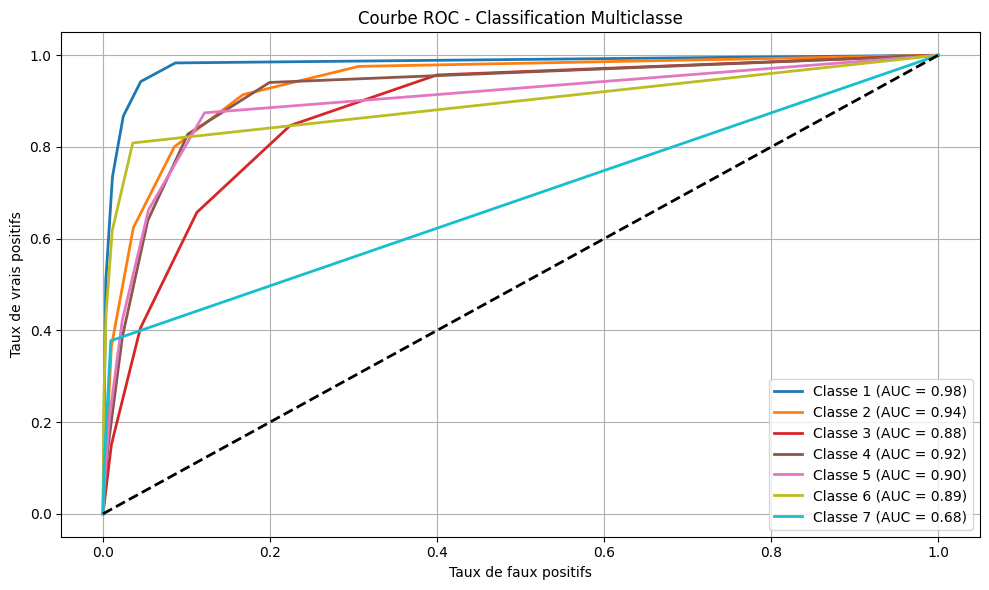

In [7]:
# 🔹 Binarisation des labels (7 classes -> 1 à 7)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# 🔹 Prédiction des probabilités
y_score = knn.predict_proba(X_test)

# 🔹 Calcul des courbes ROC par classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 🔹 Affichage de la courbe ROC
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, color=colors(i),
             label=f'Classe {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("Courbe ROC - Classification Multiclasse")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()